In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Optional
import ee
from shapely.geometry import Point
from validate_dowscaled_et import create_ee_feature_collection

In [2]:
ee.Initialize(project="thurgau-irrigation")

## Cleaning and aggregating the hourly ET data to daily data for Rietholzbach.

The aggregation is based on the following:

1. Sum Available Hourly Data:
   - For each day, sum all the available hourly evapotranspiration (ET) measurements to obtain a partial daily total.

2. Count Available Hours:
   - Count the number of hours with available data for each day (denoted as *n*).

3. Calculate Average Hourly ET:
   - Compute the average hourly ET for the day:
     $$
     \text{Average Hourly ET} = \frac{\text{Partial Daily Total}}{n}
     $$

4. Estimate Total Daily ET:
   - Estimate the total daily ET by scaling the average hourly ET to 24 hours:
     $$
     \text{Estimated Daily Total ET} = \text{Average Hourly ET} \times 24 = \text{Partial Daily Total} \times \left( \frac{24}{n} \right)
     $$

5. Handle Missing Data:
   - If any hours are missing within a day, this method adjusts the daily total by assuming that the missing hours have similar ET rates to the average of the available hours.
   - If all data is missing for a day, the daily total is set to `NaN`.




In [3]:
def read_and_process_etl_data(
    data_folder: str, file_start: str, year_range: List[int]
) -> pd.Series:
    """
    Read, clean, and aggregate ETL data from multiple files.

    Args:
        data_folder (str): Path to the folder containing ETL data files.
        file_start (str): Common prefix of the ETL data files.
        year_range (List[int]): List of years to process.

    Returns:
        pd.Series: Daily aggregated evapotranspiration data.
    """
    all_data = []

    for year in year_range:
        filename = os.path.join(data_folder, f"{file_start}{year}.txt")
        df = pd.read_csv(
            filename,
            sep=";",
            skiprows=26,
            header=None,
            names=["datetime", "evapotranspiration", "flag"],
            dtype={"datetime": str, "evapotranspiration": float, "flag": int},
        )

        # Process datetime column
        df["datetime"] = df["datetime"].str.replace("24:00", "00:00")
        df["datetime"] = pd.to_datetime(df["datetime"], format="%d-%m-%Y %H:%M")
        df["datetime"] += pd.to_timedelta(
            (df["datetime"].dt.hour == 0).astype(int), unit="D"
        )

        df.set_index("datetime", inplace=True)
        all_data.append(df)

    combined_df = pd.concat(all_data)

    # Clean data
    cleaned_df = combined_df[
        (combined_df["flag"] != 1) & (combined_df["evapotranspiration"] != -9999)
    ]["evapotranspiration"]

    # Aggregate to daily
    daily_et = cleaned_df.resample("D").apply(
        lambda x: x.sum() * (24 / x.count()) if x.count() > 0 else np.nan
    )

    daily_et = daily_et.dropna()

    return daily_et

In [4]:
data_folder = "/Users/cooper/Desktop/Hydrosolutions/ETblue-estimation /RietholzbachData_Hirschi_etal_HESS/hourly/Evapotranspiration"
file_start = "ETL_"
year_range = range(2009, 2016)

daily_evapotranspiration = read_and_process_etl_data(data_folder, file_start, year_range)

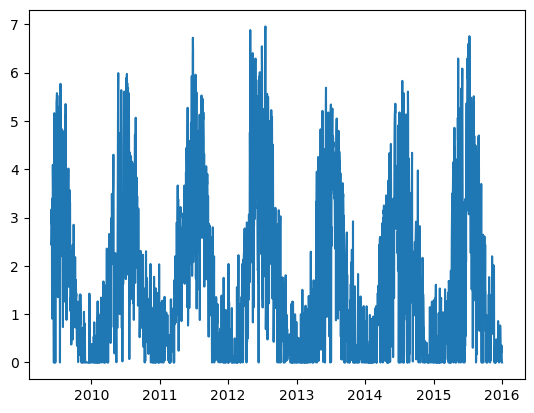

In [5]:
plt.plot(daily_evapotranspiration)

## Exporting the time series to an ee.FeatureCollection

In [11]:
station_x = 717405
station_y = 248896

fc = create_ee_feature_collection(daily_evapotranspiration, station_x, station_y)

fc.first().getInfo()

{'type': 'Feature',
 'geometry': {'type': 'Point',
  'coordinates': [-13.412753364600315, 36.16558880429034]},
 'id': '0',
 'properties': {'date_[YYYYmmdd]': '2009-06-01',
  'evapotranspiration_[mm/d]': 2.4431999999999996,
  'system:time_start': 1243814400000}}

In [7]:
# # Export the FeatureCollection to an Earth Engine asset (optional)
# task = ee.batch.Export.table.toAsset(
#     collection=fc,
#     description="evapotranspiration_timeseries_rietholzbach",
#     assetId="projects/thurgau-irrigation/assets/Thurgau/ETFluxNet/ET_timeseries_rietholzbach_2009_2015",
# )
# task.start()

## Checking that the export ran successfully

In [9]:
point_fc = ee.FeatureCollection(
    "projects/thurgau-irrigation/assets/Thurgau/ETFluxNet/ET_timeseries_rietholzbach_2009_2015"
).sort("system:time_start")

# Print the first feature to verify
point_fc.first().getInfo()

{'type': 'Feature',
 'geometry': {'type': 'Point',
  'coordinates': [-13.412753364600315, 36.16558880429034]},
 'id': '00000000000000000000',
 'properties': {'date_[YYYYmmdd]': '2009-06-01',
  'evapotranspiration_[mm/d]': 2.4431999999999996,
  'system:time_start': 1243814400000}}